<a href="https://colab.research.google.com/github/JuanOcampo29/Finanzas/blob/main/Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taller 3
##Hecho por Juan Alejandro Ocampo Sanchez, Juan Pablo Moncada y María Paula Lizarazo Espinosa

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%pip install --quiet yfinance
import yfinance as yf
import cvxpy as cp
from scipy.optimize import minimize
from scipy.optimize import linprog
from scipy.stats import norm
%pip install --quiet statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
def retorno(x):
  precios = yf.download(x,start="2017-12-01",end="2022-12-31",interval="1Mo")["Adj Close"]
  retornos=np.log(precios/precios.shift()).dropna()
  return(retornos)

In [ ]:
jnj=retorno("JNJ")
mcd=retorno("MCD")
ko=retorno("KO")
v=retorno("V")
jpm=retorno("JPM")
r_indice=retorno("^DJI")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##Punto 1

#####a. Estimar los parámetros del modelo de mercado de las cinco acciones y construir un DataFrame donde se resuman los caculos de: retornos esperados (promedio), volatilidades, betas, retornos estimados (CAPM) y el coeficiente de determinación de cada uno.

In [ ]:
E_i=r_indice.mean()

In [ ]:
matriz_covarianza=np.cov([jnj,mcd,ko,v,jpm]) 
matriz_covarianza

array([[0.00261955, 0.00148781, 0.00150197, 0.00164424, 0.00166346],
       [0.00148781, 0.00305672, 0.00214278, 0.00231358, 0.00196834],
       [0.00150197, 0.00214278, 0.00325382, 0.00229552, 0.00224803],
       [0.00164424, 0.00231358, 0.00229552, 0.00461816, 0.00314078],
       [0.00166346, 0.00196834, 0.00224803, 0.00314078, 0.0064407 ]])

In [ ]:
# Estimación lineal
def beta(X):
  slope, intercept, r, p, std_err = stats.linregress(r_indice,X) #slope es la pendiente de la recta de regresión, es decir, el beta
  return(slope)

In [ ]:
#Se calculan los betas con la función previamente definida
BJNJ=beta(jnj)
BMCD=beta(mcd)
BKO=beta(ko)
BV=beta(v)
BJPM=beta(jpm)

In [ ]:
#Se calcula el retorno esperado por CAPM
capm_jnj=E_i*BJNJ
capm_mcd=E_i*BMCD
capm_ko=E_i*BKO
capm_v=E_i*BV
capm_jpm=E_i*BJPM

In [ ]:
#Se calcula el retorno esperado (Promedio)
mean_jnj=jnj.mean()
mean_mcd=mcd.mean()
mean_ko=ko.mean()
mean_v=v.mean()
mean_jpm=jpm.mean()

In [ ]:
#Se calculan las volatilidades de los activos como la desviación de los retornos 
vol_jnj=jnj.std()
vol_mcd=mcd.std()
vol_ko=ko.std()
vol_v=v.std()
vol_jpm=jpm.std()

In [ ]:
#Se define una función que me va a entregar el r^2
def coef(X):
  slope, intercept, r, p, std_err = stats.linregress(r_indice, X) #slope es la pendiente de la recta de regresión, es decir, el beta
  return(r**2)

In [ ]:
#Se calcula el coeficiente de determinación de los retornos 
RJNJ=coef(jnj)
RMCD=coef(mcd)
RKO=coef(ko)
RV=coef(v)
RJPM=coef(jpm)

In [ ]:
df = pd.DataFrame({' ' : ['JNJ', 'MCD', 'KO', 'V', 'JPM'],
        'Retorno esperado (Promedio)' : [mean_jnj,mean_mcd,mean_ko,mean_v,mean_jpm],
        'Retorno esperado (CAPM)' : [capm_jnj,capm_mcd,capm_ko,capm_v,capm_jpm],
        'Beta' : [BJNJ,BMCD,BKO,BV,BJPM],
        'Volatilidad' : [vol_jnj,vol_mcd,vol_ko,vol_v,vol_jpm],
        'R^2' : [RJNJ,RMCD,RKO,RV,RJPM]})
df

,,Retorno esperado (Promedio),Retorno esperado (CAPM),Beta,Volatilidad,R^2
0,JNJ,0.006112,0.002914,0.595904,0.051181,0.389592
1,MCD,0.009071,0.003495,0.714679,0.055288,0.480231
2,KO,0.008096,0.003404,0.696103,0.057042,0.427994
3,V,0.010547,0.004862,0.994319,0.067957,0.615270
4,JPM,0.006188,0.005934,1.213557,0.080254,0.657160


##### b. Construya un plano riesgo-retorno en el que se relacionen los retornos estimados del CAPM y las betas de los activos.

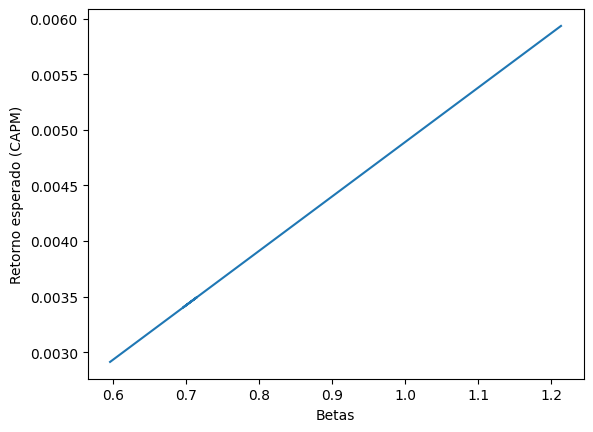

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('Retorno esperado (CAPM)')
ax.set_xlabel('Betas')
plt.plot(df["Beta"],df["Retorno esperado (CAPM)"])
plt.show();

## Punto 2



##### Escoja 5 acciones que hagan parte del índice Dow Jones (DJI). Con la información histórica de estas acciones para un periodo de al menos 5 años con periodicidad mensual y con cierre a Dic-2022, construya el portafolio óptimo tangente (máximo ratio de Sharpe).

In [ ]:
# Portafolio óptimo tangente (Máximo Ratio de SharpeSharpe
n=len(df.index)
x = cp.Variable(n)
objetivo = cp.Minimize(cp.quad_form(x, matriz_covarianza))
restricciones = [x @ df["Retorno esperado (Promedio)"] == 1,x>=0]
prob = cp.Problem(objetivo, restricciones)
prob.solve()
wpt = x.value/sum(x.value)
rpt = wpt.T @ df["Retorno esperado (Promedio)"]
sigmapt = np.sqrt(wpt.T@matriz_covarianza@wpt)
wpt

array([1.35353324e-01, 4.40183882e-01, 1.22725412e-01, 3.01737382e-01,
       1.42321469e-20])

In [ ]:
#Portafolio tangente 
sigmapt,rpt

(0.04987315359128971, 0.00899641937074677)

##### a. Presentar el grafico de pesos y sus medidas de retorno esperado y volatilidad. Nota:tomar solo posiciones largas en el portafolio.

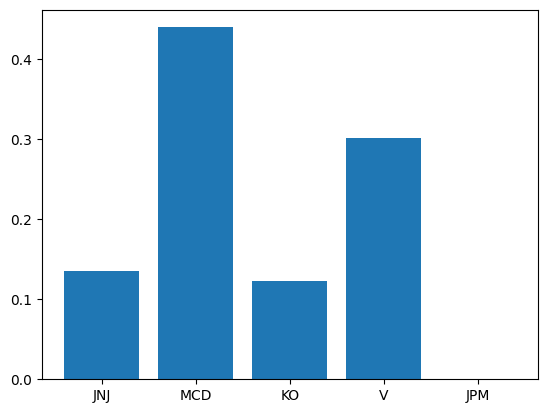

In [ ]:
plt.bar(df.index,wpt)
x=[0,1,2,3,4]
plt.xticks(x,df[" "]);

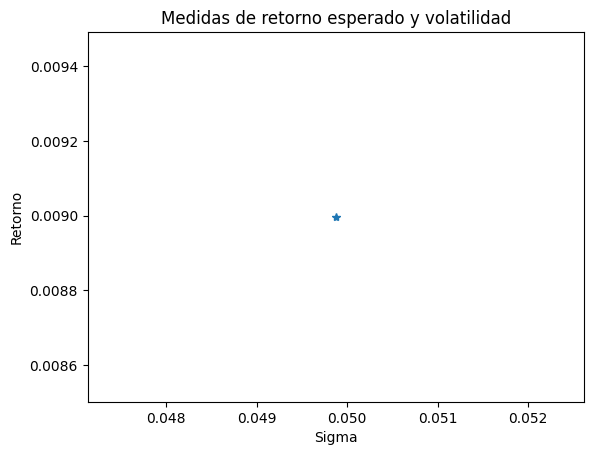

In [ ]:
plt.plot(sigmapt,rpt,marker="*")
plt.title("Medidas de retorno esperado y volatilidad")
plt.xlabel("Sigma")
plt.ylabel("Retorno")
plt.show();

##### b. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el modelo estándar o paramétrico.

In [ ]:
#Para calcular el VaR parametrico es necesario primero calcular el portafolio de mínima varianza global
c = np.array([matriz_covarianza])
n=5
x = cp.Variable(n)
objective=cp.Minimize(cp.quad_form(x,matriz_covarianza))
constraints = [cp.sum(x)==1, x>=0]
prob=cp.Problem(objective,constraints)
results=prob.solve()
wpmvg=x.value
wpmvg

array([0.49023653, 0.25807451, 0.19743164, 0.0188379 , 0.03541942])

In [ ]:
a=pd.concat([jnj,mcd,ko,v,jpm],axis=1)
a.columns=(df[" "])

In [ ]:
# VaR Paramétrico al 95% de confianza
retornos=a@wpmvg
rp = retornos.mean()
sigmap = retornos.std()
alpha = 0.05
VaRp = rp - norm.ppf(1-alpha)*sigmap 
VaRp

-0.06720344284367537

In [ ]:
# VaR Paramétrico al 99% de confianza
retornos2=a@wpmvg
rp2 = retornos2.mean()
sigmap2 = retornos2.std()
alpha2 = 0.01
VaRp2 = rp2 - norm.ppf(1-alpha2)*sigmap2 
VaRp2

-0.09809393724791647

##### c. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el modelo de estimación histórica.

Percentil

In [ ]:
np.percentile(retornos,5)

-0.0715471081400305

In [ ]:
np.percentile(retornos2,1)

-0.09802634606356125

##### d. Utilice el método de Monte Carlo para construir una muestra aleatoria de 10.000 portafolios. Con esta muestra aleatoria calcular el VaR de simulación del portafolio.

In [ ]:
# Uniform distribution
distr=np.random.normal(rp,sigmap,10000) # Entre más números aleatorios mejor
sim=np.percentile(distr,5)
sim

In [ ]:
plt.hist(distr,bins="sturges")
plt.axvline(sim, color='r', label='VaR');

#####e. ¿Se encuentran diferencias significativas entre el VaR de simulación y el VaR de paramétrico?

No, la diferencia se evidencia a partir del tercer decimal por lo que, en este caso, no sería significativa.

## Punto 3

#####a. Escoja una acción de su preferencia. Con la información histórica con cierre a Dic-2022,
estime los parámetros μ y σ. Utilice el método de Monte Carlo para generar una muestra
aleatoria de 10.000 posibles valores del precio del activo en el instante t = 1. Presente
gráficamente las primeras 20 trayectorias del proceso.

In [ ]:
precios = yf.download('AAPL', end='2022-12-31', interval='1Mo')['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()

[*********************100%***********************]  1 of 1 completed


In [ ]:
mup3 = retornos.mean()
sigmap3 = retornos.std()

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [ ]:
T=1 
mu=mup3*12
sigma =sigmap3*np.sqrt(12)
S0=precios[-1]
NS = 10000 
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

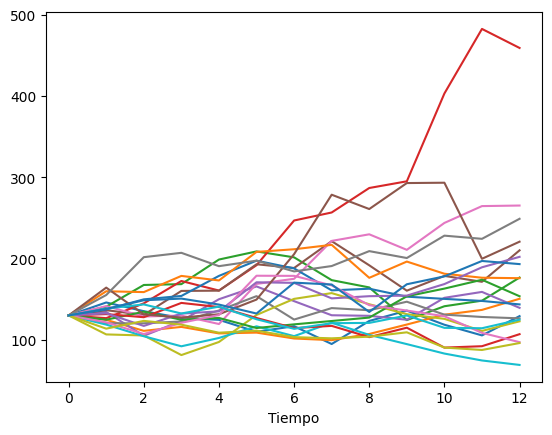

In [ ]:
plt.plot(np.transpose(St[:21])) 
plt.xlabel("Tiempo")

#####b. Construya el histograma de los precios y retornos al final del periodo (t = 1). ¿qué puede concluir de la forma de los histogramas?

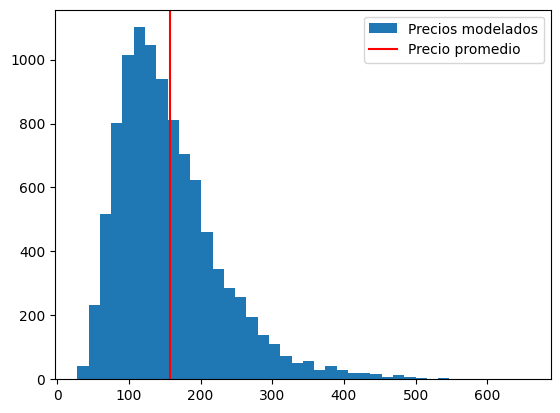

In [ ]:
#HISTOGRAMA DE PRECIOS
plt.hist(St[:,-1], bins=40
         , label='Precios modelados')
plt.axvline(St[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

Lo que se puede concluir gráficamente del histograma es que se asemeja un poco a una distribución normal. Sin emabrgo, se evidencia que la cola derecha es más pesada y la mayor densidad de datos no se encuentra en el valor de la media.

#####c. Demuestre que el valor del precio simulado de la acción en T converge a ST exp{μ T}.

In [ ]:
St[:,-1].mean()  

156.95982425499645

In [ ]:
S0 * np.exp(mu * T) 

156.70467426747572

#####d. Calcule la probabilidad de que el precio de la acción sea inferior a S0.

In [ ]:
a=pd.DataFrame(St[:,-1]<S0)
a.replace({"True":1})
valormenor=np.sum(a[0])
probabilidad=(valormenor/NS)*100

In [ ]:
print('La probabilidad de que el precio sea menor al precio de diciembre de 2022 es de',probabilidad,'%')

La probabilidad de que el precio sea menor al precio de diciembre de 2022 es de 41.88 %


## Punto 4

##### a. Utilice el método de Monte Carlo para realizar una simulación de 10000 posibles trayectorias (NS) de este proceso considerando los siguientes valores: X0 = 1, μ = 3, σ =0.3, T = 5, NS = 100, dt = T/m. Presente gráficamente los resultados para las primeras 10 trayectorias del proceso.

In [ ]:
t0 = 0
T = 5 
NS=100
M=60
dt = T/M 
k = 1 
mu = 3
sigma = 0.3
steps=60
y0=1


t = np.linspace(t0,T,steps) 

x = np.zeros((NS,steps))

sigma_4 = sigma * np.sqrt(2/k)
sqrtdt = np.sqrt(dt)
for i in range(steps - 1):
  for w in range(NS-1):
    x[w,i + 1] = x[w,i] + dt * (-(x[w,i] - mu) / k) + \
        sigma_4 * sqrtdt * np.random.randn()
OU=x
OU


array([[0.        , 0.06886478, 0.46437123, ..., 2.71904143, 2.57178815,
        2.48029864],
       [0.        , 0.32865769, 0.56552389, ..., 2.70974286, 2.84408462,
        2.87786508],
       [0.        , 0.34802993, 0.44486633, ..., 3.55933556, 3.54714542,
        3.53331236],
       ...,
       [0.        , 0.31000924, 0.42094627, ..., 2.86994428, 2.73438276,
        2.59275274],
       [0.        , 0.3988679 , 0.35374156, ..., 3.38903197, 3.46830341,
        3.6015942 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

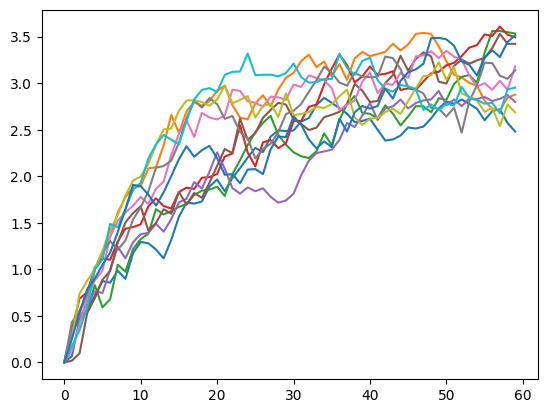

In [ ]:
#gráfico
plt.plot(np.transpose(OU[:11]));

##### b. A partir de los observado en las simulaciones realizadas en el punto anterior, ¿qué puede concluir acerca del valor esperado y la varianza del proceso Ornstein-Uhlenbeck en el largo plazo?

In [ ]:
mu4= OU[:,-1].mean()
st4=(OU[:,-1].std())**2
print('El valor esperado de acuerdo a las simulaciones realizadas es',mu4,'y su varianza es',st4,'. Esto quiere decir que el valor esperado'
 'es bastante cercano a la media y que la volatilidad no es tan alta')

El valor esperado de acuerdo a las simulaciones realizadas es 2.984731162691959 y su varianza es 0.1902739682702959 . Esto quiere decir que el valor esperadoes bastante cercano a la media y que la volatilidad no es tan alta


##### c. De acuerdo con la ecuación 1, ¿cuál es la distribución de probabilidad del proceso Ornstein-Uhlenbeck?

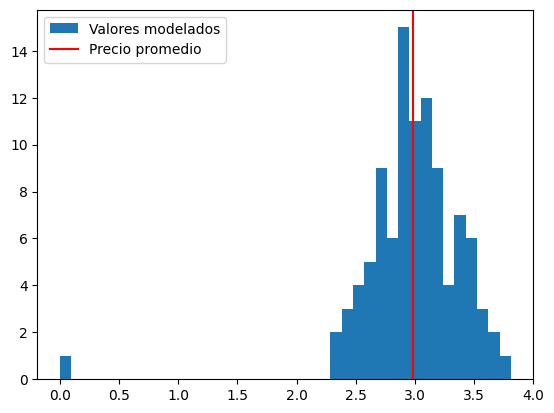

In [ ]:
#HISTOGRAMA 
plt.hist(OU[:,-1], bins=40
         , label='Valores modelados')
plt.axvline(OU[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

Si bien existen distintos datos atipicos, se puede evidenciar una distribución que tiende a la normal.

##### d. El proceso Ornstein-Uhlenbeck se suelen utilizar para modelar la dinámica de la tasa corta de interés. Por ejemplo, si rt denota el valor de la tasa corte de interés en el mercado, esta se puede modelar como:

rt+dt = rt + (μ– rt
)dt + σ(Wt+dt − Wt)

Teniendo en cuenta los siguientes parámetros: r0 = 0. 03, μ = 0. 05, σ = 0. 15, T = 1, NS = 100, dt = T/m; simule 100 posibles valores de la tasa de corta en el instante T = 1, y utilice el valor promedio obtenido para valorar un bono cero cupón y facial 100 con vencimiento en T. Presente gráficamente los resultados para las primeras 10 trayectorias del
proceso.

In [ ]:
t0 = 0.03
T = 1 
NS=100 
M=12
dt = T/M 
k = 1 
mu = 0.05
sigma = 0.15
steps=12
Y0=0.03


t = np.linspace(t0,T,steps) # time axis

x = np.zeros((NS,steps))
x[:,0]=t0

sigma_41 = sigma * np.sqrt(2/k)
sqrtdt = np.sqrt(dt)
for i in range(steps - 1):
  for w in range(NS-1):
    x[w,i + 1] = x[w,i] + dt * (-(x[w,i] - mu) / k) + \
        sigma_41 * sqrtdt * np.random.randn()
OU2=x
OU2

In [ ]:
plt.plot(np.transpose(OU2[:11]));

In [ ]:
b=pd.DataFrame(OU2[:,-1]<mu)
b.replace({"True":1})
valormenor=np.sum(b[0])
probabilidad4=(valormenor/NS)*100

In [ ]:
print('La probabilidad de que la tasa se encuentre por debajo de su media es',probabilidad4,'por lo que dependiendo de esta se podría cambiar la opción de tomar el bono o no')


##Punto 5

**Gold Futures (GC=F)**

a. Serie histórica de los precios

[*********************100%***********************]  1 of 1 completed


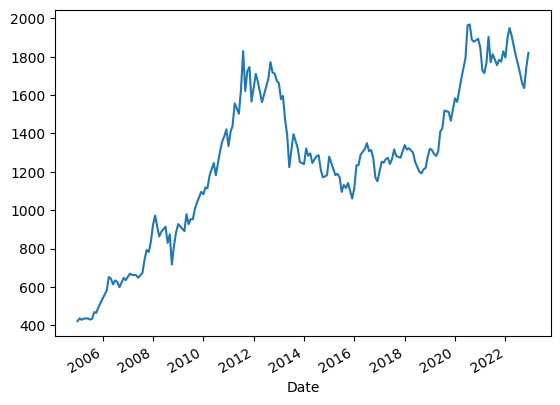

In [ ]:
preciosg = yf.download("GC=F",start="2005-01-01",end="2022-12-31",interval="1Mo")["Adj Close"]
logg=np.log(preciosg/preciosg.shift())
preciosg.plot();

b. Prueba de estacionariedad Dickey-Fuller (ADF)

In [ ]:
pruebag = adfuller(preciosg)
print("ADF test: %f" % pruebag[0])
print("P-value: %f" % pruebag[1])
print("Citical values:")
for key, value in pruebag[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -1.606097
P-value: 0.480530
Citical values:
	1%: -3.466398
	5%: -2.877380
	10%: -2.575214


La serie no estacionaria a un nivel de significancia del 5%

c. Simulación (Browniano)

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [ ]:
mug=logg.mean()
mug

0.007945085137944513

In [ ]:
sigmag=logg.std()
sigmag

0.05112087578204146

In [ ]:
T = 1 
mu = mug*12
sigma = sigmag*np.sqrt(12)
S0 = preciosg[-1]
NS = 100
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)


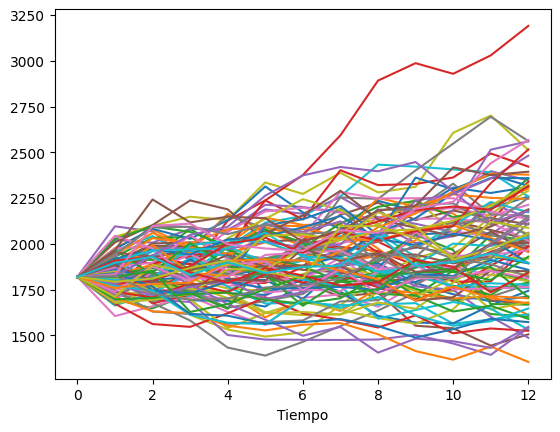

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo");

**Cooper (HG=F)**

a. Serie histórica de precios

[*********************100%***********************]  1 of 1 completed


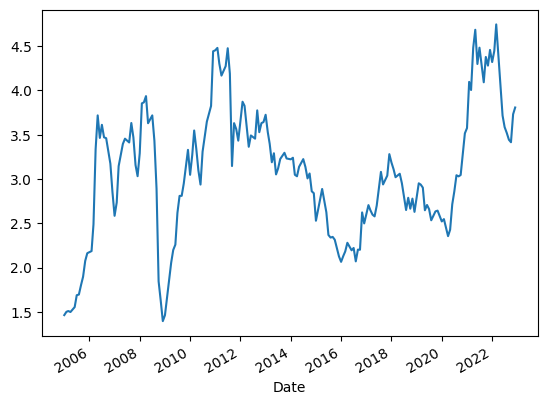

In [ ]:
preciosc = yf.download("HG=F",start="2005-01-01",end="2022-12-31",interval="1Mo")["Adj Close"]
logc=np.log(preciosc/preciosc.shift())
preciosc.plot();

b. Prueba de estacionariedad Dickey-Fuller (ADF)

In [ ]:
pruebac = adfuller(preciosc)
print("ADF test: %f" % pruebac[0])
print("P-value: %f" % pruebac[1])
print("Citical values:")
for key, value in pruebac[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -3.058196
P-value: 0.029806
Citical values:
	1%: -3.466598
	5%: -2.877467
	10%: -2.575260


La serie no es estacionaria a un nivel de significancia del 5%

c. Simulación Browniano

In [ ]:
muc=logc.mean()
muc

0.005195425186365247

In [ ]:
sigmac=logc.std()
sigmac

0.08429396075588047

In [ ]:
T = 1
mu5 = muc*12
sigma5 = sigmac*np.sqrt(12)
S0 = preciosc[-1]
NS = 100
M = 12 
St = PathsGBM(S0,mu5,sigma5,T,NS,M)

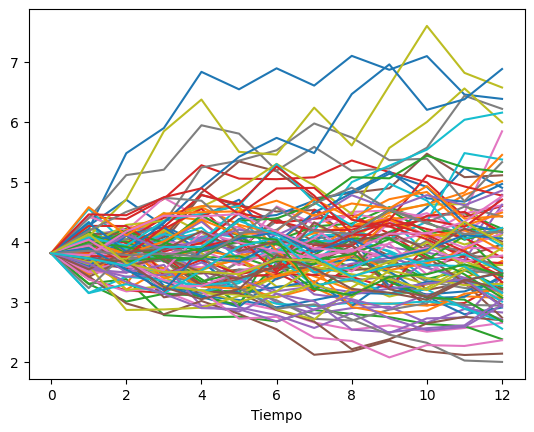

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo");

**Coffee Futures(KC=F)**

a. Serie histórica de precios

[*********************100%***********************]  1 of 1 completed


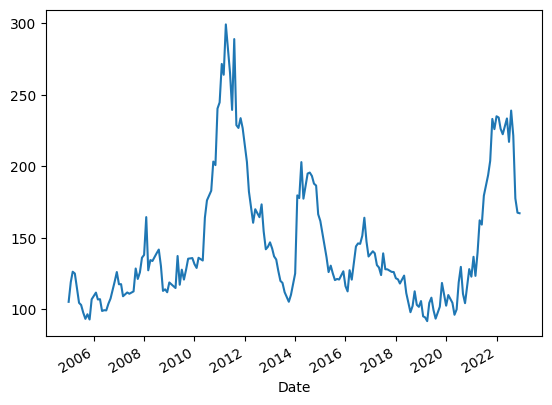

In [ ]:
preciosx = yf.download("KC=F",start="2005-01-01",end="2022-12-31",interval="1Mo")["Adj Close"]
logx=np.log(preciosx/preciosx.shift())
preciosx.plot();

b. Prueba de estacionariedad Dickey-Fuller (ADF)

In [ ]:
pruebax = adfuller(preciosx)
print("ADF test: %f" % pruebax[0])
print("P-value: %f" % pruebax[1])
print("Citical values:")
for key, value in pruebax[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -3.329256
P-value: 0.013620
Citical values:
	1%: -3.467420
	5%: -2.877826
	10%: -2.575452


La serie no es estacionaria a un nivel de significancia del 5%

c. Simulación Browniano

In [ ]:
mux=logx.mean()
mux

0.0025135896764549534

In [ ]:
sigmax=logx.std()
sigmax

0.09008188698883393

In [ ]:
T = 1
mu = mu*12
sigma = sigmax*np.sqrt(12)
S0 = preciosx[-1]
NS = 100
M = 12
St = PathsGBM(S0,mu,sigma,T,NS,M)

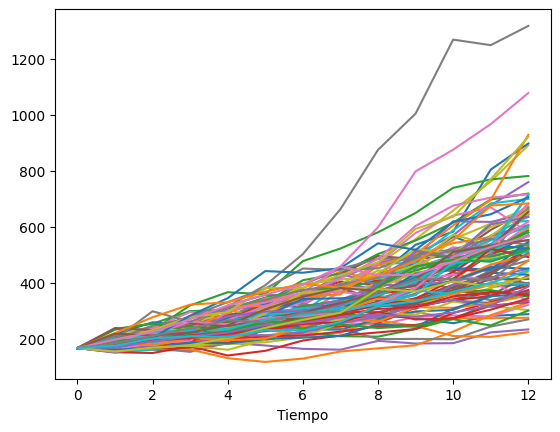

In [ ]:
plt.plot(np.transpose(St))
plt.xlabel("Tiempo");